In [1]:
import numpy as np
import torch
import copy

In [2]:
from sklearn.manifold import TSNE
from sklearn.manifold import Isomap

In [3]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from matplotlib import cm

# https://plotly.com/python/creating-and-updating-figures/
import plotly.graph_objects as go

In [4]:
import sys
sys.path.append('../') # now can access entire repository, (important when running locally)

# from orbit_datasets import neworbits, versatileorbits, staticorbits
from ldcl.data import neworbits, versatileorbits, staticorbits, physics
from ldcl.tools import nn_metric
from ldcl.models import branch

# Data Generation

In [136]:
orbits_dataset, folder = physics.get_dataset("../data_configs/orbit_config_default.json", "../../saved_datasets")
#print(f"Using dataset {folder}...")
#orbits_dataset = physics.combine_datasets(["../data_configs/single_orbit.json", "../data_configs/L_vary.json"], [0.5, 0.5], "../../saved_datasets")

orbits_loader = torch.utils.data.DataLoader(
    dataset = orbits_dataset,
    shuffle = True,
    batch_size = 1,
)

In [137]:
def getRepresentations(encoder_location_or_encoder):
    if isinstance(encoder_location_or_encoder, str):
        branch_encoder = torch.load(encoder_location_or_encoder, map_location=torch.device('cpu'))     
    else:
        print("using encoder")
        branch_encoder = encoder_location_or_encoder
    branch_encoder.eval()
    
    encoder_outputs_list = []
    target_values = []
    inputs = []

    for it, (input1, input2, y) in enumerate(orbits_loader):
        predicted_representation = branch_encoder(input1.float()).detach().numpy()[0]
        inputs.append(input1.float().numpy()[0])
        encoder_outputs_list.append(predicted_representation)

        #append conserved quantities to the end of the representation for plotting, y = (1, )
        #[2=phi0,3=energy,4=angular_momentum] discard [0=eccentricity, 1=semimajor_axis]
        target_values.append(np.array( (y["phi0"].item(),y["H"].item(),y["L"].item()) ))
        
    encoder_outputs = np.vstack(encoder_outputs_list)
    target_values = np.vstack(target_values)

    phi0_c_values = target_values[:,0]
    energy_c_values = target_values[:,1]
    angular_momentum_c_values = target_values[:,2]
    
    return encoder_outputs, [phi0_c_values, energy_c_values, angular_momentum_c_values], np.array(inputs)

# Visualizing Models

In [138]:
# max is 10240
NUM_SHOWN = 10000

In [266]:
ENCODER_PATH = "../saved_models/eight_mini_cubes_0.15_1/final_encoder.pt"

# ENCODER_PATH = "saved_models/3Dorbits_mseNCE/40_encoder.pt"
# ENCODER_PATH = "saved_models/3Dorbits_mseNCE/80_encoder.pt"

# ENCODER_PATH = "saved_models/4Dorbits_rmseNCE/final_encoder.pt"
# ENCODER_PATH = "saved_models/4Dorbits_mseNCE/40_encoder.pt"

In [267]:
encoder_outputs, conserved_quantities, inputs = getRepresentations(ENCODER_PATH)
#encoder_outputs, conserved_quantities, inputs = getRepresentations(branch.branchEncoder(encoder_out=3))

reorder_quantities = np.array([1, 2, 0])

train_settings = "../data_configs/eight_mini_cubes_temp.json"
cq = np.array(conserved_quantities)[reorder_quantities, :]
is_in = physics.is_in_distribution(train_settings, np.transpose(cq))

#select = np.logical_not(is_in)
select = [True] * np.shape(encoder_outputs)[0]
rescale_arr = np.array([6.28, 1.0, 1.0])
evaluator = nn_metric.Orbit_Evaluator(encoder_outputs[select], np.array(conserved_quantities)[:, select])
evaluator.evaluate()
print(evaluator.variance / rescale_arr, evaluator.max_dev / rescale_arr)

[0.01302964 0.0042266  0.02247952] [0.49845384 0.2461482  0.84430494]


In [268]:
dims = [encoder_outputs[:NUM_SHOWN,i] for i in range(encoder_outputs.shape[1])]
phi0_c_values, energy_c_values, angular_momentum_c_values = conserved_quantities
inputs = inputs[:NUM_SHOWN, :]
conserved_quantities = [phi0_c_values[:NUM_SHOWN], energy_c_values[:NUM_SHOWN], angular_momentum_c_values[:NUM_SHOWN]]

(10000, 3)
(10000, 2)
0.0
0.0
0.0


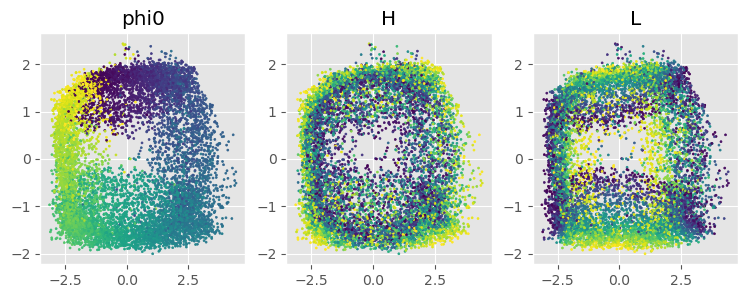

In [270]:
### conserved_quantities = [phi0_c_values, energy_c_values, angular_momentum_c_values]

viridis = cm.get_cmap('viridis', 512)
plasma = cm.get_cmap('plasma', 512)
ylorrd = cm.get_cmap('YlOrRd', 512)
pubugn = cm.get_cmap('PuBuGn', 512)

def blank(x): # transparent
    return np.zeros((np.size(x), 4))

# Settings
inds_map = viridis# color you want for in-distribution points seen during training
outds_map = viridis # color you want for out-of-distribution points only seen during testing
inds_size, outds_size = 12,12
plot_quantity = "H"
train_settings = "../data_configs/eight_mini_cubes.json" # points here are counted as "in distribution"
color_mode = "actual" # "actual" or "ranking"
# End settings

# dimensionality reduction

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
dimspca = np.transpose(np.array(dims))
print(dimspca.shape)
dimspca = pca.fit_transform(dimspca)
print(dimspca.shape)

fig = plt.figure(figsize=(9,3))

for var in range(3):
    ax = fig.add_subplot(1, 3, var + 1)
    all_quantities = ["phi0", "H", "L", "x", "y", "v_x", "v_y"]
    plot_quantity = all_quantities[var]
    color = np.concatenate((conserved_quantities, np.transpose(inputs)))[all_quantities.index(plot_quantity)]
    if color_mode == "actual":
        color = color - np.quantile(color, 0.01) # make it safe against outliers
        if np.max(color) > 0:
            color = color / np.quantile(color, 0.99)
        color = np.maximum(color, 0)
        color = np.minimum(color, 1)
        print(np.min(color))
    elif color_mode == "ranking":
        color = color.argsort().argsort() / len(color)
        print(np.histogram(color), np.quantile(color, 0.05))

    reorder_quantities = np.array([1, 2, 0])

    cq = np.array(conserved_quantities)[reorder_quantities, :]
    is_in = physics.is_in_distribution(train_settings, np.transpose(cq))
    color = np.where(np.repeat(is_in[:, np.newaxis], 4, axis=1), inds_map(color), outds_map(color))
    size = np.where(is_in, inds_size, outds_size)

    ax.scatter(dimspca[:, 0], dimspca[:, 1], color=color, s=2)
    ax.title.set_text(["phi0", "H", "L"][var])
    



In [ ]:
### conserved_quantities = [phi0_c_values, energy_c_values, angular_momentum_c_values]

viridis = cm.get_cmap('viridis', 512)
plasma = cm.get_cmap('plasma', 512)
ylorrd = cm.get_cmap('YlOrRd', 512)
pubugn = cm.get_cmap('PuBuGn', 512)

def blank(x): # transparent
    return np.zeros((np.size(x), 4))

# Settings
inds_map = viridis# color you want for in-distribution points seen during training
outds_map = viridis # color you want for out-of-distribution points only seen during testing
inds_size, outds_size = 12,12
plot_quantity = "x"
train_settings = "../data_configs/single_orbit.json" # points here are counted as "in distribution"
color_mode = "actual" # "actual" or "ranking"
# End settings

# dimensionality reduction

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
dimspca = np.transpose(np.array(dims))
print(dimspca.shape)
dimspca = pca.fit_transform(dimspca)
print(dimspca.shape)

fig = plt.figure(figsize=(9,3))

    all_quantities = ["phi0", "H", "L", "x", "y", "v_x", "v_y"]
    plot_quantity = all_quantities[var]
    color = np.concatenate((conserved_quantities, np.transpose(inputs)))[all_quantities.index(plot_quantity)]
    if color_mode == "actual":
        color = color - np.quantile(color, 0.01) # make it safe against outliers
        if np.max(color) > 0:
            color = color / np.quantile(color, 0.99)
        color = np.maximum(color, 0)
        color = np.minimum(color, 1)
        print(np.min(color))
    elif color_mode == "ranking":
        color = color.argsort().argsort() / len(color)
        print(np.histogram(color), np.quantile(color, 0.05))

    reorder_quantities = np.array([1, 2, 0])

    cq = np.array(conserved_quantities)[reorder_quantities, :]
    is_in = physics.is_in_distribution(train_settings, np.transpose(cq))
    color = np.where(np.repeat(is_in[:, np.newaxis], 4, axis=1), inds_map(color), outds_map(color))
    size = np.where(is_in, inds_size, outds_size)

    ax.scatter(dimspca[:, 0], dimspca[:, 1], color=color, s=2)
    ax.title.set_text(["phi0", "H", "L"][var])

0.0


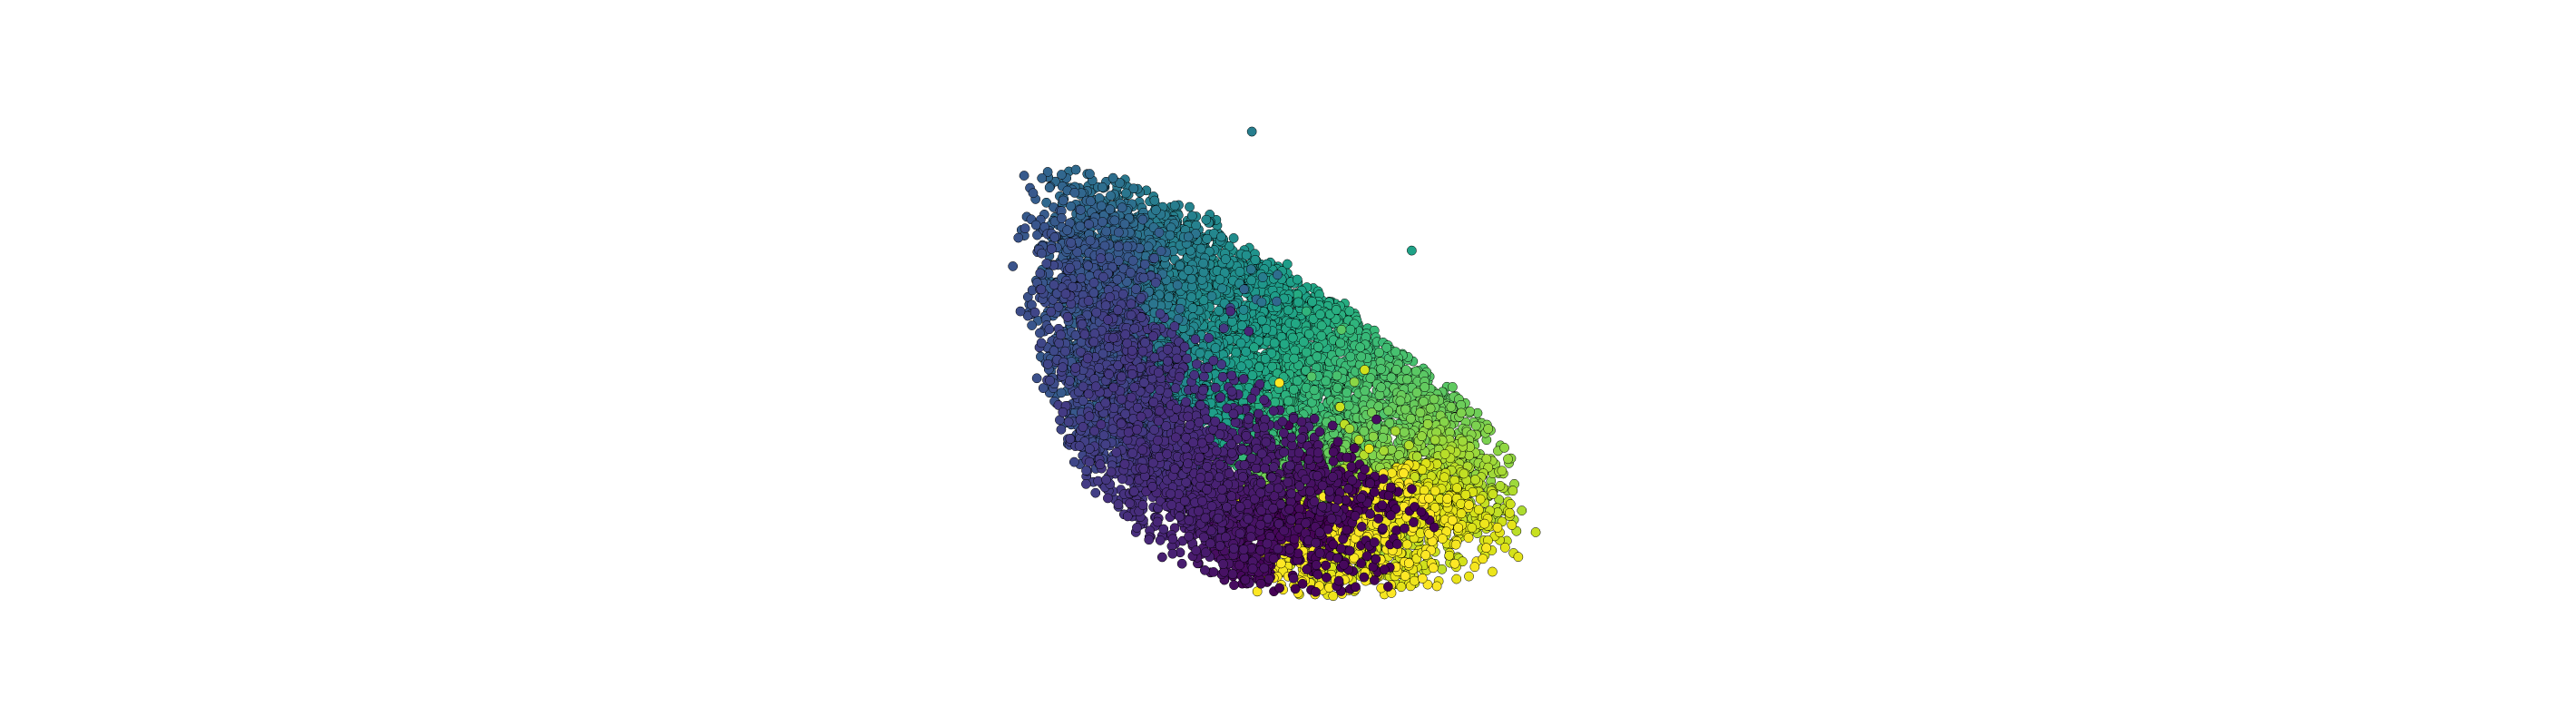

In [263]:
plot_quantity = "phi0"
all_quantities = ["phi0", "H", "L", "x", "y", "v_x", "v_y"]
color = np.concatenate((conserved_quantities, np.transpose(inputs)))[all_quantities.index(plot_quantity)]
if color_mode == "actual":
    color = color - np.quantile(color, 0.01) # make it safe against outliers
    if np.max(color) > 0:
        color = color / np.quantile(color, 0.99)
    color = np.maximum(color, 0)
    color = np.minimum(color, 1)
    print(np.min(color))
elif color_mode == "ranking":
    color = color.argsort().argsort() / len(color)
    print(np.histogram(color), np.quantile(color, 0.05))

reorder_quantities = np.array([1, 2, 0])

cq = np.array(conserved_quantities)[reorder_quantities, :]
is_in = physics.is_in_distribution(train_settings, np.transpose(cq))
color = np.where(np.repeat(is_in[:, np.newaxis], 4, axis=1), inds_map(color), outds_map(color))
size = np.where(is_in, inds_size, outds_size)
labels = np.transpose(np.concatenate((conserved_quantities, np.transpose(inputs))))
labels = [str(x) for x in labels]

camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=0.5, y=1.25, z=0)
)

fig = go.Figure(
        data=[go.Scatter3d(
        x=dims[0],
        y=dims[1],
        z=dims[2],
        mode='markers',
        marker=dict(
            size=size,
            color=color,
            line=dict(width=1, color='black'),
            opacity=1
        ),
        text=labels
    )],
    layout=go.Layout(height=800, width=1000)
)
fig.update_layout(scene_camera=camera)
fig.update_scenes(xaxis_visible=False, yaxis_visible=False,zaxis_visible=False )
fig.show()

### Dimensional Reduction with t-SNE

We also try t-SNE. There only seems to be one manifold so it's not really playing to t-SNE's strengths in this case but I'm saving everything in case it's useful.

In [12]:
dr = TSNE(n_components=3, init = 'random',learning_rate = 'auto', perplexity=20)

projected_outputs = dr.fit_transform(encoder_outputs) # projected_outputs.shape = (10240,3)

In [ ]:
dims = [projected_outputs_3d[:NUM_SHOWN,i] for i in range(projected_outputs_3d.shape[1])]

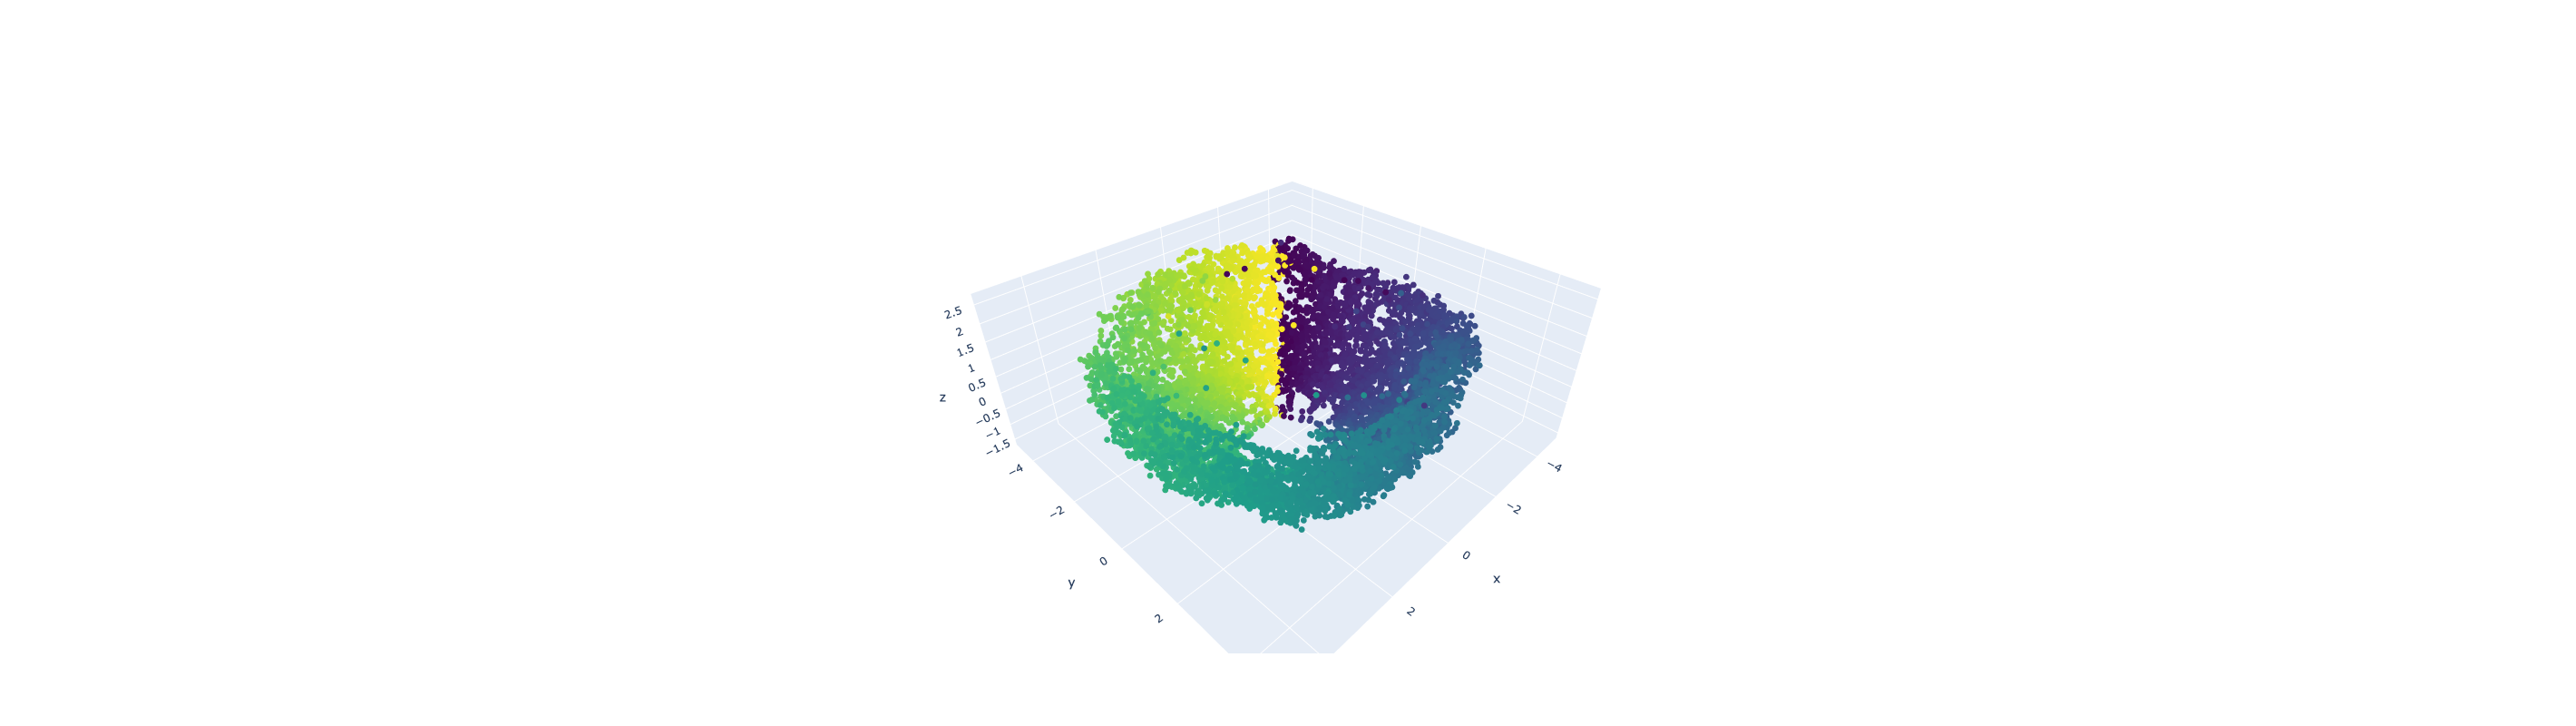

In [29]:
# conserved_quantities = [phi0_c_values, energy_c_values, angular_momentum_c_values]
color = conserved_quantities[0]

fig = go.Figure(
        data=[go.Scatter3d(
        x=dims[0],
        y=dims[1],
        z=dims[2],
        mode='markers',
        marker=dict(
            size=4,
            color=color, # set color to an array/list of desired values
            colorscale='viridis',
            opacity=1
        )
    )],
    layout=go.Layout(height=800, width=1000)
)
fig.show()